Collected From: https://www.kaggle.com/datasets/ranitsarkar01/yulu-bike-sharing-data

## About Yulu

Yulu is India’s leading micro-mobility service provider, which offers unique vehicles for the daily commute. Starting off as a mission to eliminate traffic congestion in India, Yulu provides the safest commute solution through a user-friendly mobile app to enable shared, solo and sustainable commuting.
Yulu zones are located at all the appropriate locations (including metro stations, bus stands, office spaces, residential areas, corporate offices, etc) to make those first and last miles smooth, affordable, and convenient!

Yulu has recently suffered considerable dips in its revenues. They have contracted a consulting company to understand the factors on which the demand for these shared electric cycles depends. Specifically, they want to understand the factors affecting the demand for these shared electric cycles in the Indian market.



**`How you can help here?`**

The company wants to know:

Which variables are significant in predicting the demand for shared electric cycles in the Indian market?
How well those variables describe the electric cycle demands?



**`Concepts Used:`**

Bi-Variate Analysis 2-sample t-test: testing for difference across populations ANNOVA Chi-square



**`How to begin:`**

Import the dataset and do usual exploratory data analysis steps like checking the structure & characteristics of the dataset

Try establishing a relation between the dependent and independent variable (Dependent “Count” & Independent: Workingday, Weather, Season etc)



**`Select an appropriate test to check whether:`**

Working Day has effect on number of electric cycles rented

No. of cycles rented similar or different in different seasons

No. of cycles rented similar or different in different weather

Weather is dependent on season (check between 2 predictor variable)

Set up Null Hypothesis (H0) State the alternate hypothesis (H1) Check assumptions of the test (Normality, Equal Variance). You can check it using Histogram, Q-Q plot or statistical methods like levene’s test, Shapiro-wilk test (optional)

Please continue doing the analysis even If some assumptions fail (levene’s test or Shapiro-wilk test) but double check using visual analysis and report wherever necessary

Set a significance level (alpha) Calculate test Statistics. Decision to accept or reject null hypothesis. Inference from the analysis

## Column Profiling:

datetime: datetime

`season:` season (1: spring, 2: summer, 3: fall, 4: winter)

`holiday:` whether day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)

`workingday:` if day is neither weekend nor holiday is 1, otherwise is 0.

`weather:` 1: Clear, Few clouds, partly cloudy, partly cloudy 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

`temp:` temperature in Celsius

`atemp:` feeling temperature in Celsius

`humidity:` humidity

`windspeed:` wind speed

`casual:` count of casual users

`registered:` count of registered users

`count:` count of total rental bikes including both casual and registered

In [207]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin
import warnings
warnings.filterwarnings("ignore")
sns.set_palette('rocket')

In [208]:
# importing datasets
df = pd.read_csv('/Users/zehan/Documents/Python/Projects/Hypothesis Testing - Yulu Business Case/yulu_bike_sharing_dataset.csv',parse_dates=['datetime'])
display(df.head())
display(df.info())

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


None

This data seems to have no null values.<br>
Here Holiday data is included in the workingday column.<br>
Casual and Registered is summed to counts column.<br>
Also, temp and atemp gives us the similar info.<br>
So we can ignore these columns - holiday,casual,registered,temp<br>
We can do hypothesis testing to see which factor has effects to Counts. Let's consider 95% confidence interval. But first let's view the distributions.

# Distribution of all columns

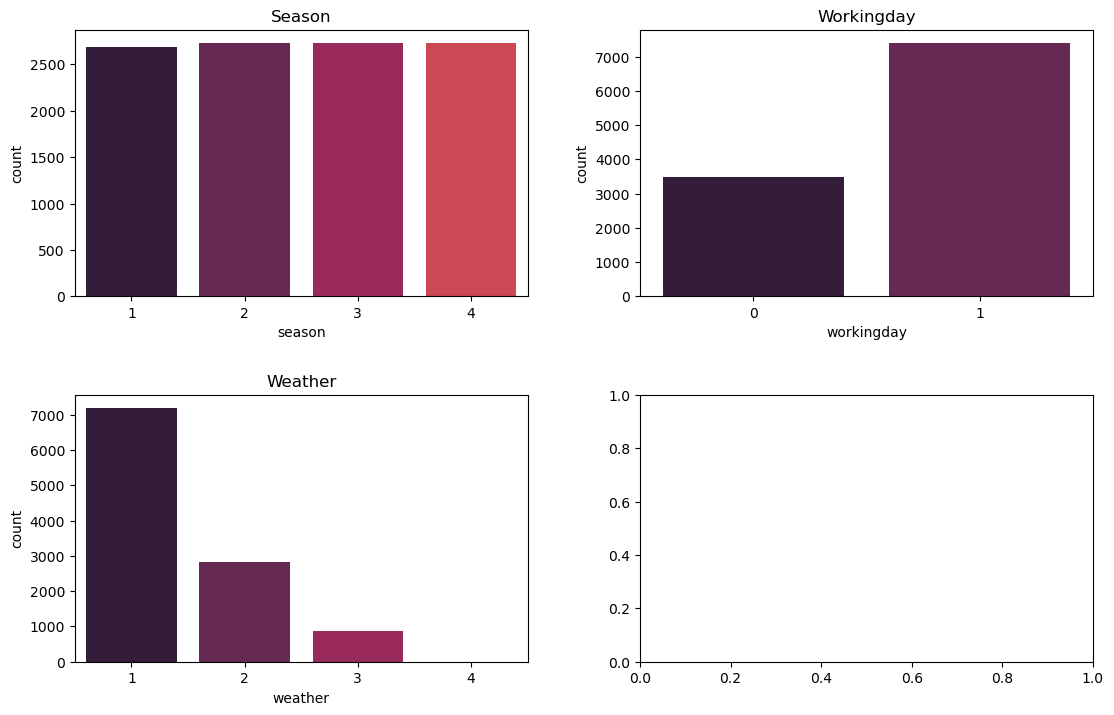

In [209]:
columns = ['season','workingday','weather']
fig, ax = plt.subplots(2,2,figsize=(12,8))
fig.tight_layout(pad=5.0)
i = 0;j= 0
for column in columns:
    plot_df = sns.countplot(data=df,x=column,ax=ax[i,j])
    plot_df.set_title(str.capitalize(column))
    j=j+1
    if j%2==0:i=i+1;j=0

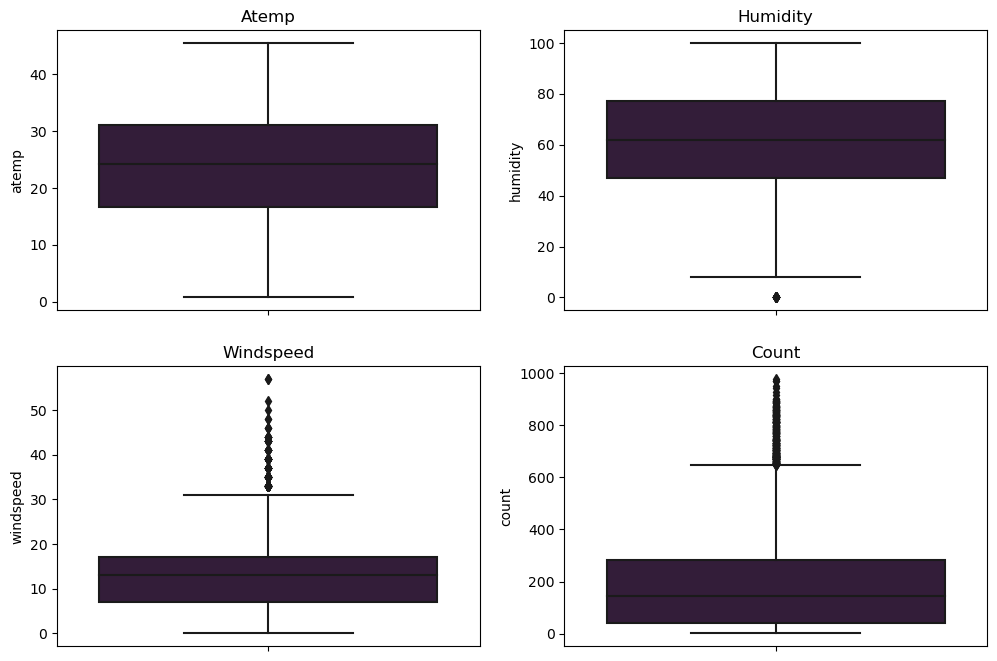

In [210]:
columns = ['atemp','humidity','windspeed','count']
fig, ax = plt.subplots(2,2,figsize=(12,8))
i = 0;j= 0
for column in columns:
    plot_df = sns.boxplot(data=df,y=column,ax=ax[i,j])
    plot_df.set_title(str.capitalize(column))
    j=j+1
    if j%2==0:i=i+1;j=0

Here, season colum is uniformly distributed. We got twice the workingday than holiday/weekend. Weather is mostly clear, sometimes we get mist or snowfall. But rarely a bad weather. Which is expected as people don't get out on bike on bad weather.<br>
atemp, humidity has normal distribution. But windspeed and count seems to be right skewed with too many outliers. Let's drop the outliers rows.

In [211]:
Q1 = df['count'].quantile(0.25)
Q3 = df['count'].quantile(0.75)
IQR = Q3 - Q1
df=df[(df['count']>Q1 - (1.5*IQR)) & (df['count']<Q3 + (1.5*IQR))].copy()
df.shape

(10583, 12)

# Correlation

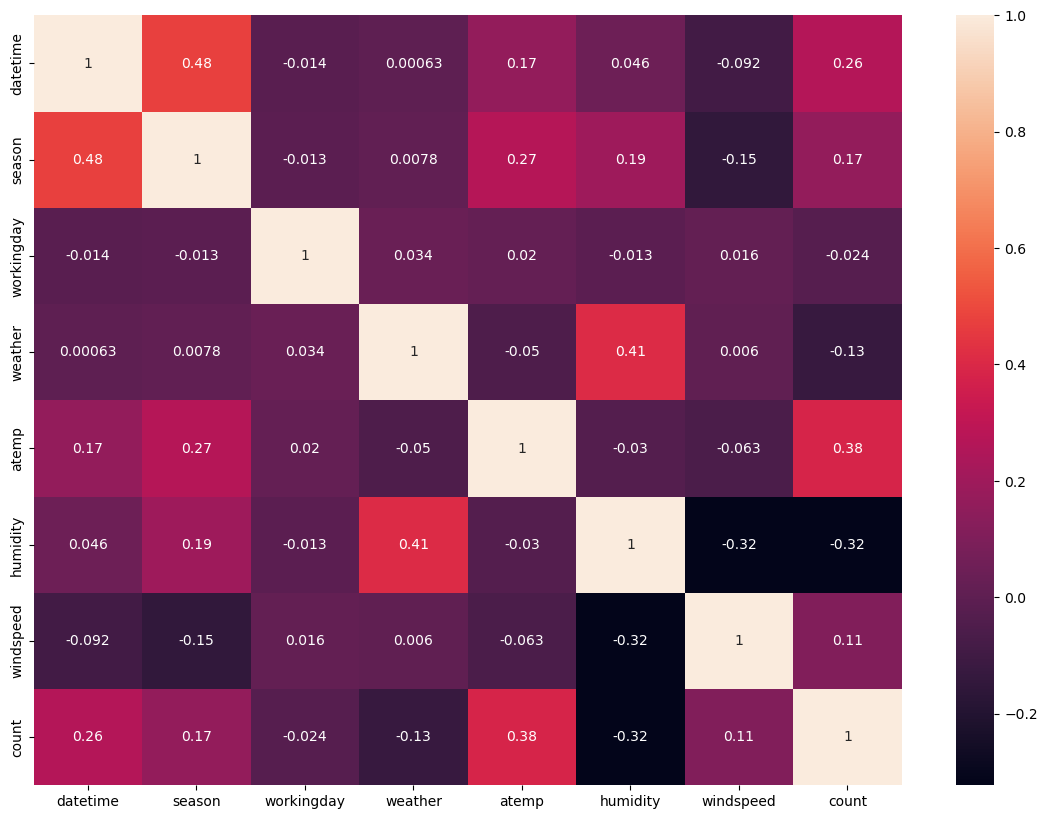

In [212]:
fig, ax = plt.subplots(figsize=(14,10))
df_corr = sns.heatmap(df.drop(columns=['holiday','casual','registered','temp']).corr(), annot=True,ax=ax)

Here, count column seems to have positive correlation with atemp and and negative with humidity. Although they around only 30-40%. But we can see people go out with bike more when the temp is high and humidity is low. Seems expected.

# Hypothesis Testing:
## 1. Does working day has effect on number of electric cycles rented?
Let, H<sub>0</sub>: Working day has No effect on number of electric cycles rented<br>
and H<sub>1</sub>: Working day has effect on number of electric cycles rented<br>

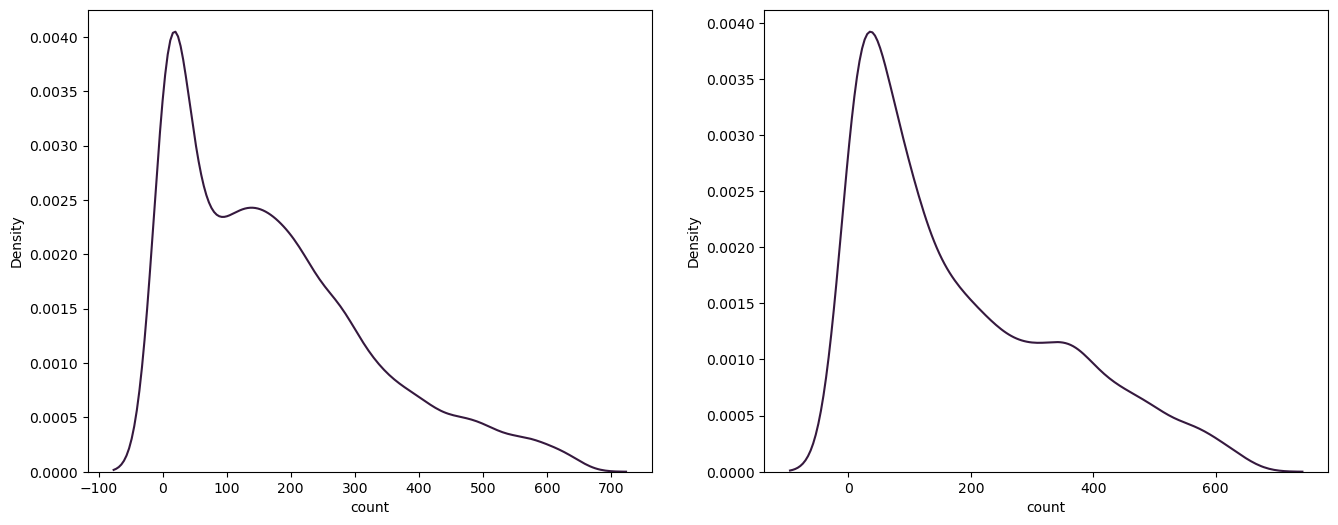

In [213]:
working_day = df.loc[df['workingday']==1,'count']
non_working_day = df.loc[df['workingday']==0,'count']

fig, ax = plt.subplots(1,2,figsize=(16,6))
working_day_plot = sns.kdeplot(working_day,ax=ax[0])
non_working_day_plot = sns.kdeplot(non_working_day,ax=ax[1])

It's a two-sided test with one categorical and one numirical column where the distribution is not normal. We 
can use a non parametric method Wilcoxon-Mann-Whitney test here.

In [214]:
pingouin.mwu(working_day,non_working_day).round(3)

,U-val,alternative,p-val,RBC,CLES
MWU,11998982.0,two-sided,0.085,0.021,0.49


Here p-val is .085 which is greater than \alpha =.05. So we fail to reject the hypothesis.<br>
That means, working day or non-working day has no effects on number of users

## 2. Does seasons has effect on number of electric cycles rented?
Let, H<sub>0</sub>: Seasons has No effect on number of electric cycles rented<br>
and H<sub>1</sub>: Seasons has effect on number of electric cycles rented<br>

<Axes: xlabel='count', ylabel='Density'>

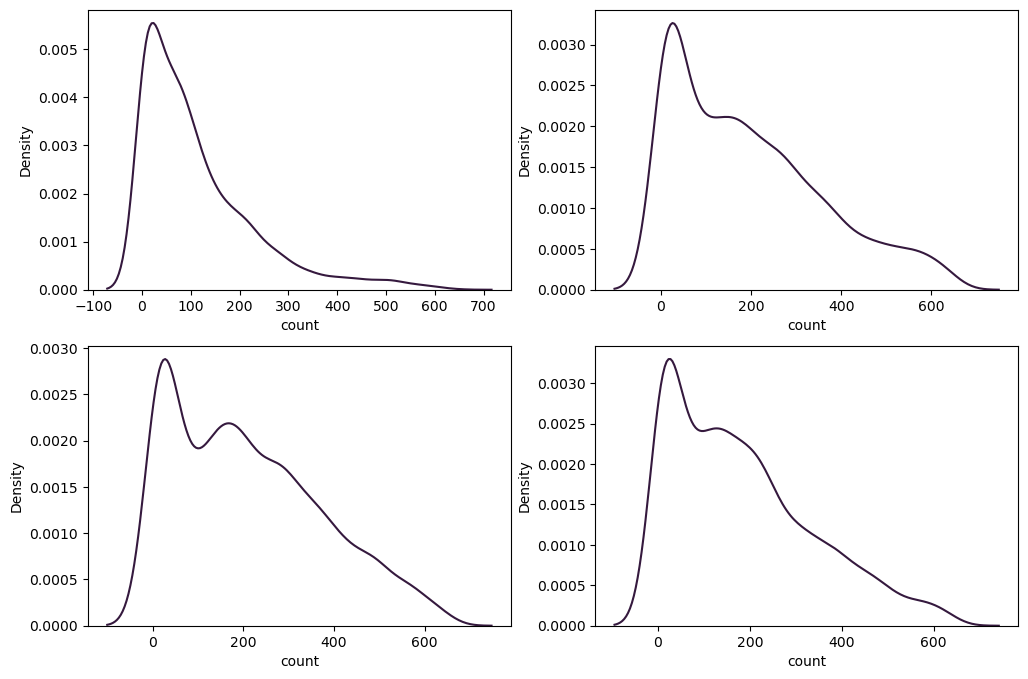

In [215]:
# 1: spring, 2: summer, 3: fall, 4: winter
spring = df.loc[df['season']==1,'count']
summer = df.loc[df['season']==2,'count']
fall = df.loc[df['season']==3,'count']
winter = df.loc[df['season']==4,'count']
fig, ax = plt.subplots(2,2,figsize=(12,8))
sns.kdeplot(spring,ax=ax[0,0])
sns.kdeplot(summer,ax=ax[0,1])
sns.kdeplot(fall,ax=ax[1,0])
sns.kdeplot(winter,ax=ax[1,1])

It's a four-sided test with one categorical and one numirical column where the distribution is not normal. We 
can use a non parametric method kruskals test here.

In [216]:
pingouin.kruskal(data=df,dv='count',between='season')

,Source,ddof1,H,p-unc
Kruskal,season,3,619.367982,6.376253e-134


Here, P-value is 6.37e-134 which is way too smaller than alpha=.05. We can reject the null hypothesis and say that, Season effects the number of riders.

([<matplotlib.axis.XTick at 0x287a149a0>,
 [Text(0, 0, 'spring'),
  Text(1, 0, 'summer'),
  Text(2, 0, 'fall'),
  Text(3, 0, 'winter')])

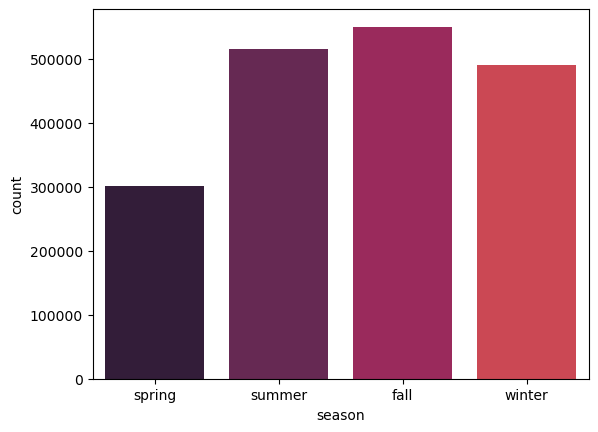

In [257]:
season_grouped = pd.DataFrame(df.groupby('season')['count'].sum())
sns.barplot(data=season_grouped,x=season_grouped.index,y='count')
plt.xticks(range(4),['spring','summer','fall','winter'])

## 3. Does weathers has effect on number of electric cycles rented?
Let, H<sub>0</sub>: Weathers has No effect on number of electric cycles rented<br>
and H<sub>1</sub>: Weathers has effect on number of electric cycles rented<br>

<Axes: xlabel='count', ylabel='Density'>

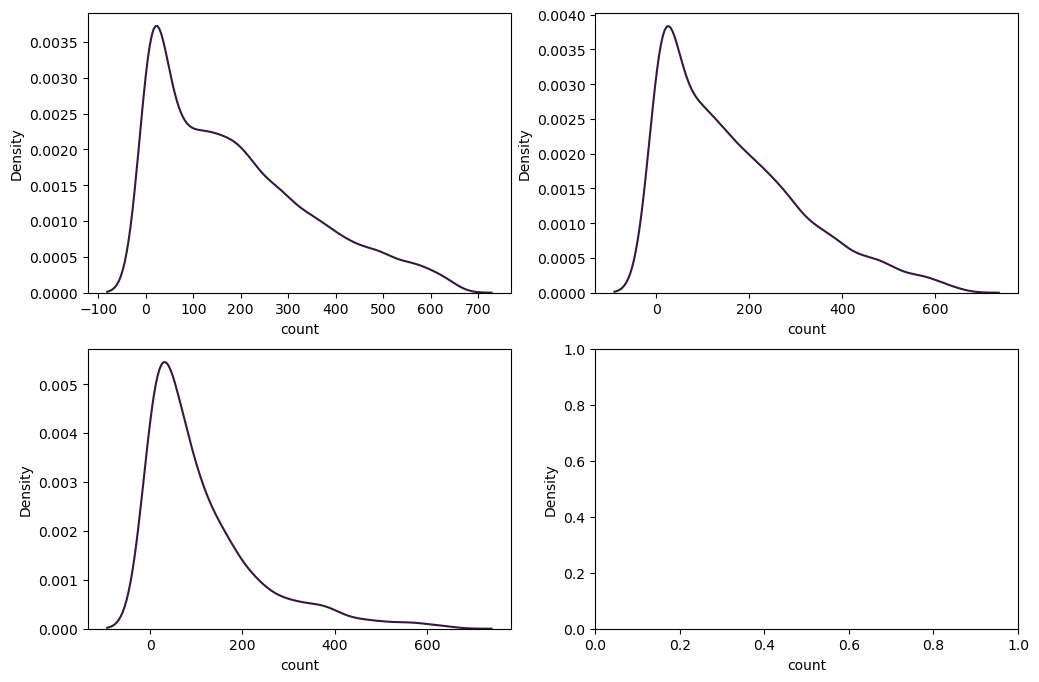

In [217]:
# 1: Clear, Few clouds, partly cloudy, partly cloudy 
# 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
# 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered  clouds
# 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
clear = df.loc[df['weather']==1,'count']
mist = df.loc[df['weather']==2,'count']
light_rain = df.loc[df['weather']==3,'count']
heavy_rain = df.loc[df['weather']==4,'count']
fig, ax = plt.subplots(2,2,figsize=(12,8))
sns.kdeplot(clear,ax=ax[0,0])
sns.kdeplot(mist,ax=ax[0,1])
sns.kdeplot(light_rain,ax=ax[1,0])
sns.kdeplot(heavy_rain,ax=ax[1,1])

It's a four-sided test with one categorical and one numirical column where the distribution is not normal. We 
can use a non parametric method kruskals test here.

In [218]:
pingouin.kruskal(data=df[['weather','count']],dv='count',between='weather')

,Source,ddof1,H,p-unc
Kruskal,weather,3,186.983176,2.736938e-40


Here, P-value is 2.73e-4 which is way too smaller than alpha=.05. We can reject the null hypothesis and say that, Weather effects the number of riders.

([<matplotlib.axis.XTick at 0x287992b60>,
 [Text(0, 0, 'clear'),
  Text(1, 0, 'mist'),
  Text(2, 0, 'light rain'),
  Text(3, 0, 'heavy rain')])

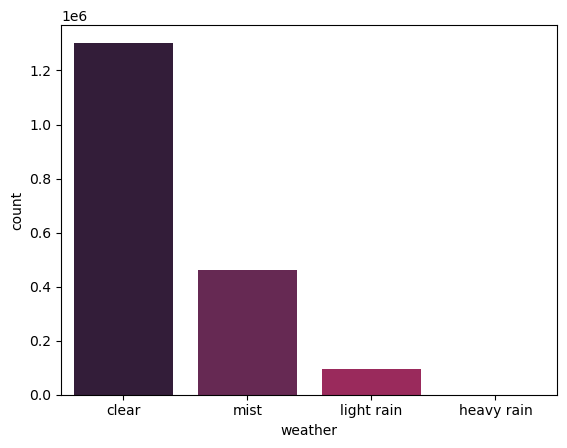

In [256]:
weather_grouped = pd.DataFrame(df.groupby('weather')['count'].sum())
sns.barplot(data=weather_grouped,x=weather_grouped.index,y='count')
plt.xticks(range(4),['clear','mist','light rain','heavy rain'])

## 4. Is weather dependent on season?
Let, H<sub>0</sub>: Weather and Season are two independent columns<br>
and H<sub>1</sub>: Weather and Season are two indifferent columns<br>

Here both the columns are categorical. So we can do a chi-square independence test.

In [219]:
expected, observed, stats=pingouin.chi2_independence(df[['season', 'weather','count']], 'season', 'weather')
stats.loc[stats['test']=='pearson']

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.0,47.165906,9.0,3.655032e-07,0.038543,0.802227


Here the P-value is 3.65e-7 which is much smaller than alpha =.05. So we can reject the null hypothesis and estabish that the weather and season column depends on each other